In [166]:
import pandas as pd
import numpy as np
import pickle

from collections import Counter

# Data Loading

In [167]:
## Save clustered tracks

CLUSTERED_FEATURES_PARQUET = '../../data/features/featureswithouttags-clustered.parquet'
clustered_tracks = pd.read_parquet(CLUSTERED_FEATURES_PARQUET)
clustered_tracks.cluster.value_counts()

cluster
3    4371
2    2611
1     265
Name: count, dtype: int64

## Label Encoding and Train/Test Splits

In [168]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split

In [169]:
features = ['acousticness',	'danceability',	'energy',	'instrumentalness',	'liveness',	'speechiness',	'tempo',	'valence'] + ['genre_top']


X = clustered_tracks[features]
y = clustered_tracks[['cluster']]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y = le.fit_transform(y)
print(Counter(y))

Counter({2: 4371, 1: 2611, 0: 265})


c:\Users\g.agluba\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


 ## Resampling

Resample using combination of oversampling and undersampling to mitigate issues with loss of information and overffiting

[Reference](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)



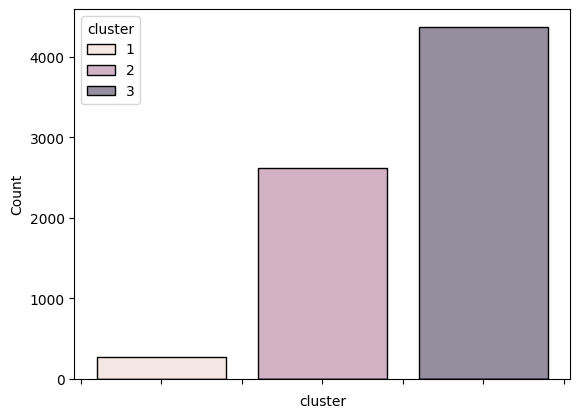

In [145]:
ax = sns.histplot(data=clustered_tracks, x="cluster", discrete=True, shrink=.8, hue='cluster').set(xticklabels=[])

In [170]:
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# define oversampling strategy


over = RandomOverSampler(sampling_strategy = {0:3000, 1:3000, 2:4371})
# fit and apply the transform
X, y = over.fit_resample(X, y)

# define undersampling strategy
under = RandomUnderSampler(sampling_strategy = {0:3000, 1:3000, 2:3000})
# fit and apply the transform
X, y = under.fit_resample(X, y)

print(Counter(y))

Counter({0: 3000, 1: 3000, 2: 3000})


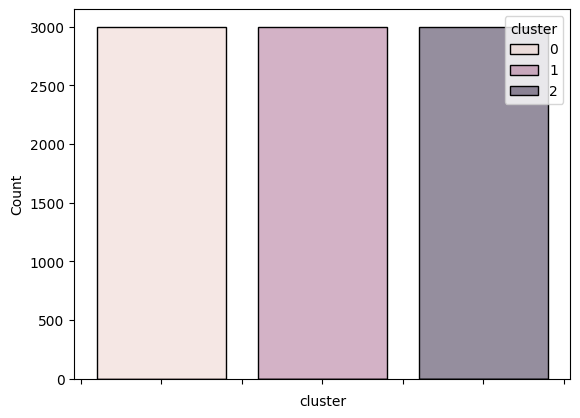

In [155]:
ax = sns.histplot(data=pd.DataFrame(y.reshape(-1,1),columns=['cluster']), x="cluster", discrete=True, shrink=.8, hue='cluster').set(xticklabels=[])


In [6]:
print(X.genre_top.value_counts())
X = X.drop(columns=['genre_top'])
X

genre_top
Classical              3000
Rock                   2693
Electronic             2495
Old-Time / Historic     412
Pop                     219
Instrumental             93
International            88
Name: count, dtype: int64


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
7361,0.994343,0.489363,0.172316,0.960462,0.113369,0.062094,77.302,0.236035
9276,0.995270,0.174413,0.033778,0.948649,0.719071,0.039492,80.912,0.039608
9426,0.952375,0.298346,0.003930,0.067443,0.107884,0.044759,42.949,0.037270
9815,0.994083,0.245693,0.038521,0.942129,0.082071,0.046651,183.180,0.038743
9409,0.986157,0.200296,0.004791,0.000146,0.082276,0.045042,122.387,0.038315
...,...,...,...,...,...,...,...,...
1201,0.987500,0.251694,0.809025,0.959604,0.119567,0.033479,112.090,0.783812
2243,0.989759,0.555386,0.211253,0.368553,0.141135,0.051831,112.577,0.346728
974,0.932161,0.353420,0.424964,0.661321,0.130184,0.052278,146.780,0.467706
2288,0.825214,0.482989,0.336223,0.535860,0.369965,0.054025,99.534,0.584531


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7 , random_state=1)


counter = Counter(y_train)
print(counter)

Counter({2: 2108, 0: 2107, 1: 2085})


In [27]:
y_train.reshape(-1,1)
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train_he = ohe.fit_transform(y_train.reshape(-1,1))
y_train_he.toarray().shape


(6300, 3)

# Supervised
---
## XGBoost
### Training

In [171]:

import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# Define hyperparameters
params = {"objective": "multi:softprob", "num_class": 3}
#evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


print("="*30)
print(f"Performing XGBoost for selected features: {features}")

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test)

n = 100
model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,

)

y_train_pred = model.predict(dtrain_reg)
y_test_pred = model.predict(dtest_reg)

print(classification_report(y_train, np.argmax(y_train_pred,axis=-1)))
print(classification_report(y_test, np.argmax(y_test_pred,axis=-1)))

MODEL_FILE_NAME = 'xgboostv2.pkl'
pickle.dump(model, open(MODEL_FILE_NAME, 'wb'))

## TEST LOAD ##
# loaded_model = pickle.load(open(MODEL_FILE_NAME, 'rb'))
# y_test_pred = model.predict(dtest_reg)
# print(classification_report(y_test, np.argmax(y_test_pred,axis=-1)))


Performing XGBoost for selected features: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'genre_top']
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2107
           1       1.00      0.99      0.99      2085
           2       0.99      1.00      0.99      2108

    accuracy                           1.00      6300
   macro avg       1.00      1.00      1.00      6300
weighted avg       1.00      1.00      1.00      6300

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       893
           1       0.82      0.79      0.80       915
           2       0.80      0.81      0.80       892

    accuracy                           0.86      2700
   macro avg       0.86      0.87      0.86      2700
weighted avg       0.86      0.86      0.86      2700



### Visualize Best Tree

In [161]:
model

In [162]:
import dtreeviz
import graphviz
import matplotlib.pyplot as plt

In [163]:
X.columns

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'genre_top'],
      dtype='object')

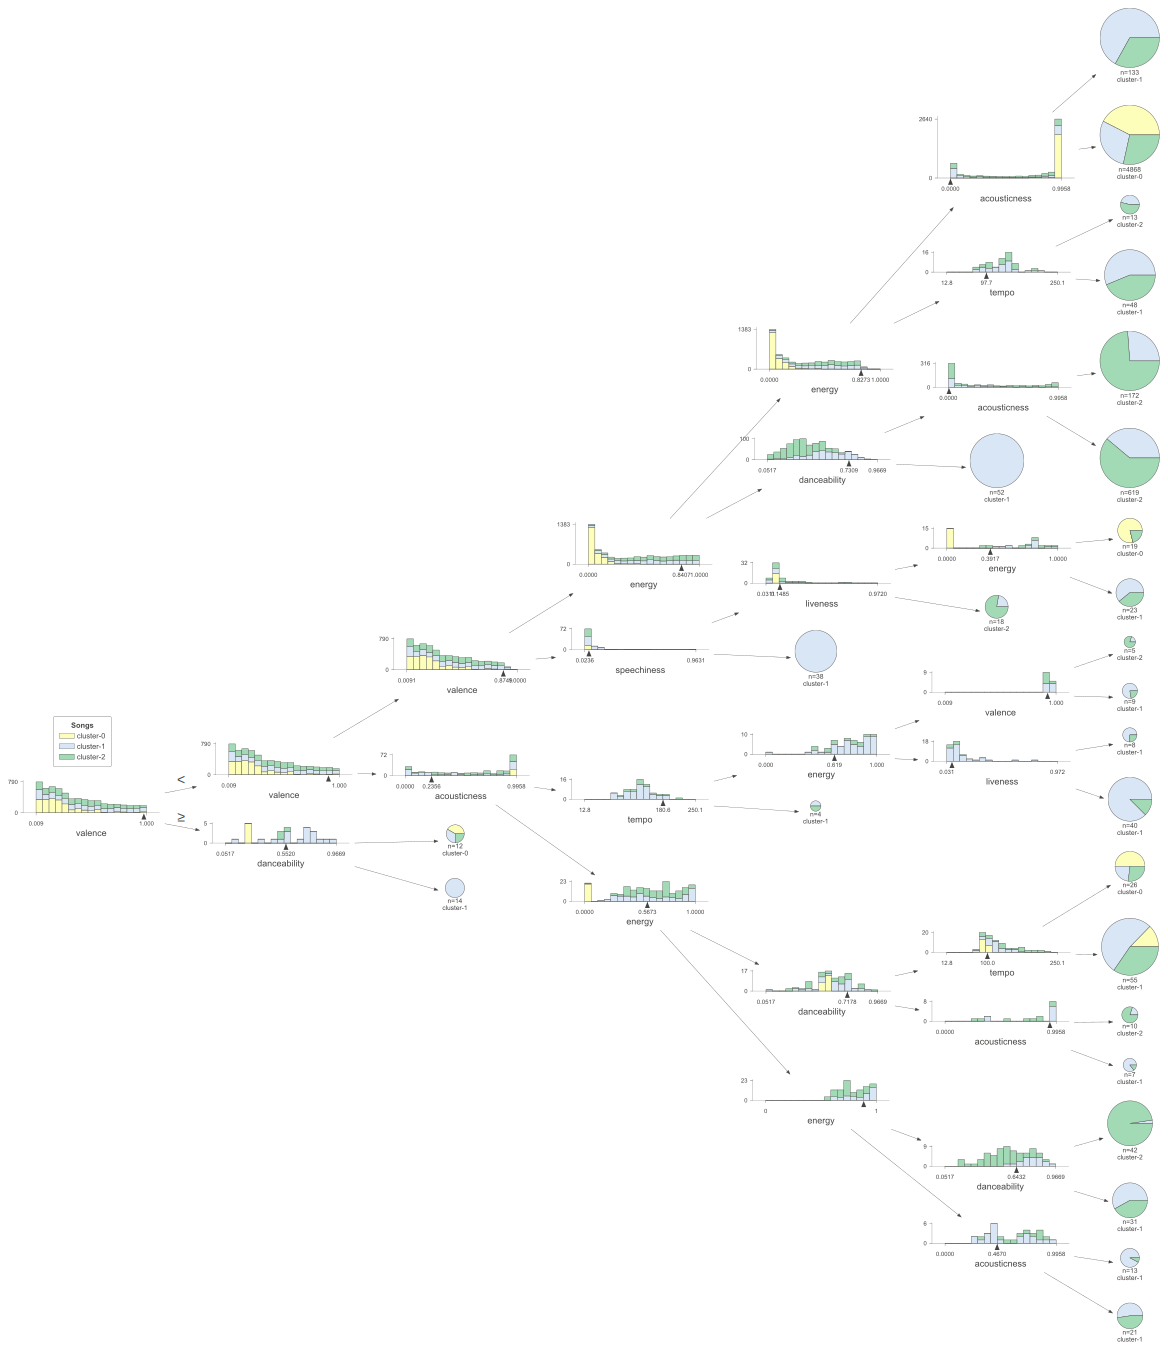

In [165]:
viz_model = dtreeviz.model(model, tree_index=n,
                           X_train=X_train, y_train=y_train, 
                           feature_names=list(X_train.columns), \
                           target_name="Songs", class_names=["cluster-0", "cluster-1","cluster-2"],
                           )
viz_model.view(orientation='LR')    

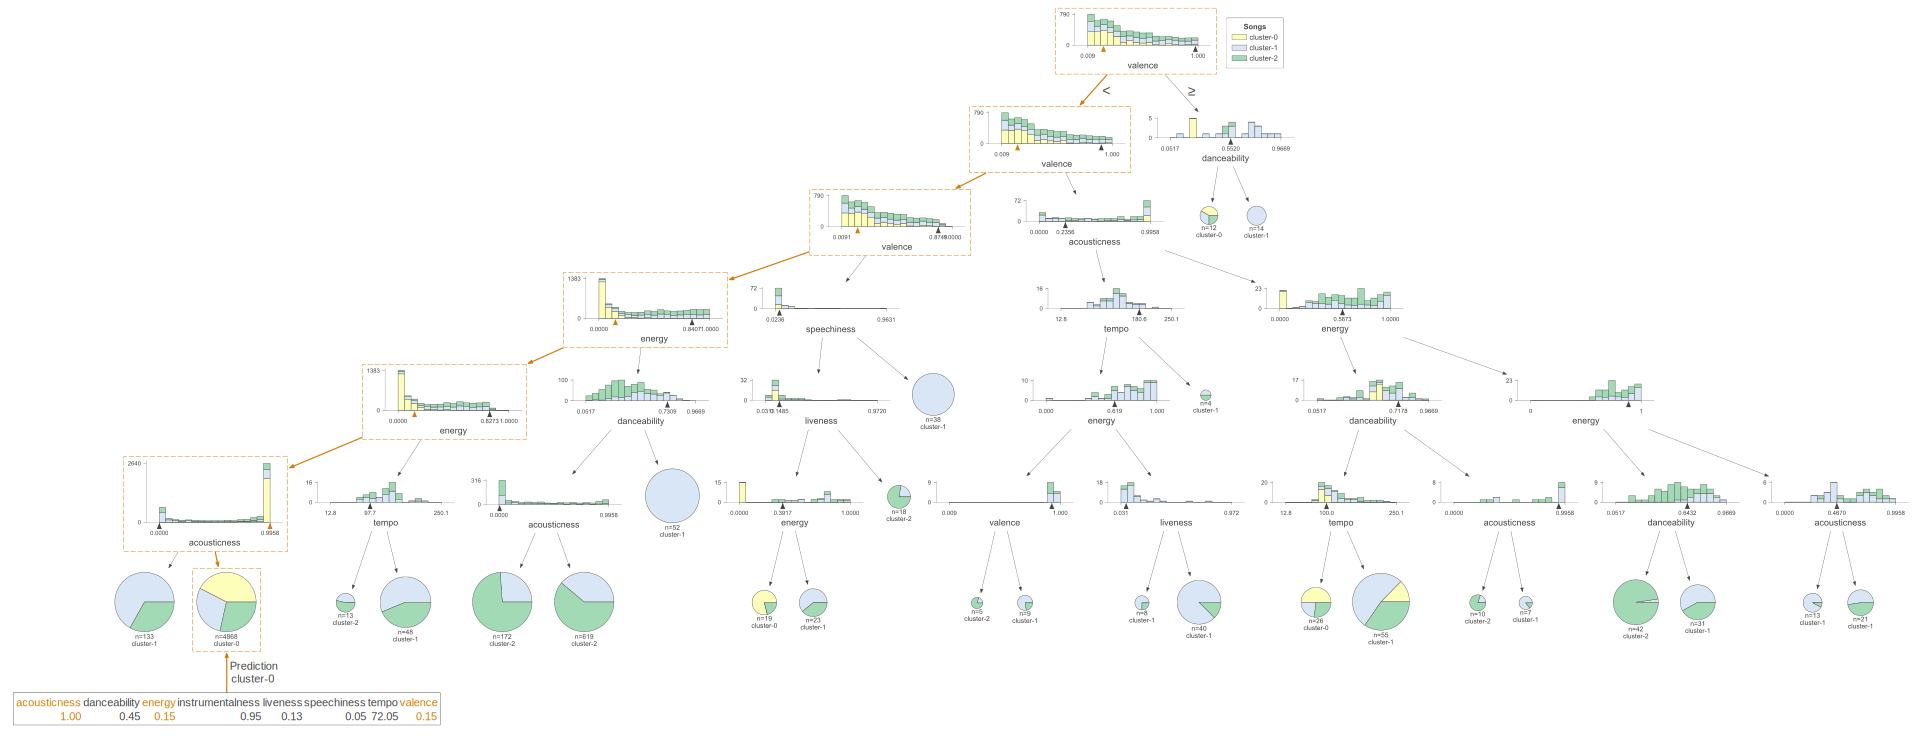

In [87]:
viz_model.view(x=X_test.values[1])

### Confusion Matrices

[Text(0.5, 1.0, 'XGBoost Music Classifier Confusion Matrix')]

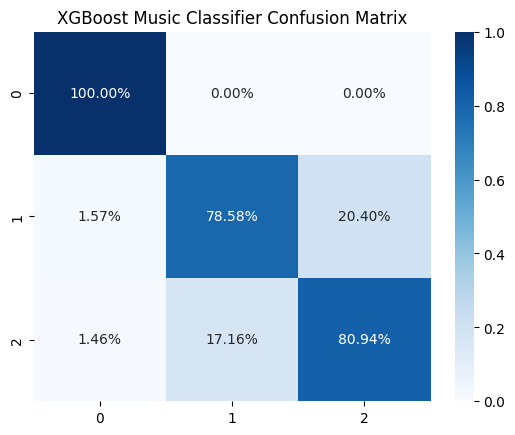

In [190]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, np.argmax(y_test_pred,axis=-1))
conf_df = pd.DataFrame(conf_matrix, index=range(conf_matrix.shape[0]), columns=range(conf_matrix.shape[1]))
#print(y_test, y_test_pred, conf_df)




sns.heatmap(conf_df/np.sum(conf_df,axis=1), annot=True, 
            fmt='.2%', cmap='Blues').set(title="XGBoost Music Classifier Confusion Matrix")

In [197]:
# aggregated_confusion_matrix_nn = np.array([[3689,  644,   10],
#        [ 187, 2263,    0],
#        [1101,  118, 2328]])


In [198]:
# sns.heatmap(aggregated_confusion_matrix_nn/np.sum(aggregated_confusion_matrix_nn,axis=-1), annot=True, 
#             fmt='.2%', cmap='Blues').set(title="ANN Human Activity Classifier Confusion Matrix")

## Adaboost with Decision Trees
### Training

In [100]:
## Building the Descision Tree Model
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
          max_depth=5,
          random_state=42)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2107
           1       0.81      0.68      0.74      2085
           2       0.74      0.82      0.78      2108

    accuracy                           0.82      6300
   macro avg       0.82      0.82      0.82      6300
weighted avg       0.82      0.82      0.82      6300

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       893
           1       0.79      0.65      0.72       915
           2       0.69      0.79      0.74       892

    accuracy                           0.79      2700
   macro avg       0.80      0.80      0.79      2700
weighted avg       0.80      0.79      0.79      2700



### Confusion Matrix

c:\Users\g.agluba\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


[Text(0.5, 1.0, 'AdaBoost Music Classifier Confusion Matrix')]

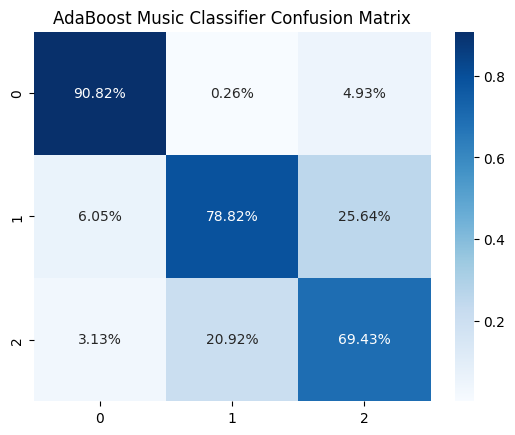

In [101]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_df = pd.DataFrame(conf_matrix, index=range(conf_matrix.shape[0]), columns=range(conf_matrix.shape[1]))
conf_df
sns.heatmap(conf_df/np.sum(conf_df), annot=True, 
            fmt='.2%', cmap='Blues').set(title="AdaBoost Music Classifier Confusion Matrix")

## KNN

In [102]:
## Standardize Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X)
X_stand = scaler.transform(X)

In [103]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2107
           1       1.00      1.00      1.00      2085
           2       1.00      1.00      1.00      2108

    accuracy                           1.00      6300
   macro avg       1.00      1.00      1.00      6300
weighted avg       1.00      1.00      1.00      6300

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       893
           1       0.70      0.67      0.68       915
           2       0.69      0.68      0.69       892

    accuracy                           0.78      2700
   macro avg       0.78      0.78      0.78      2700
weighted avg       0.78      0.78      0.78      2700



c:\Users\g.agluba\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


[Text(0.5, 1.0, 'KNN Music Classifier Confusion Matrix')]

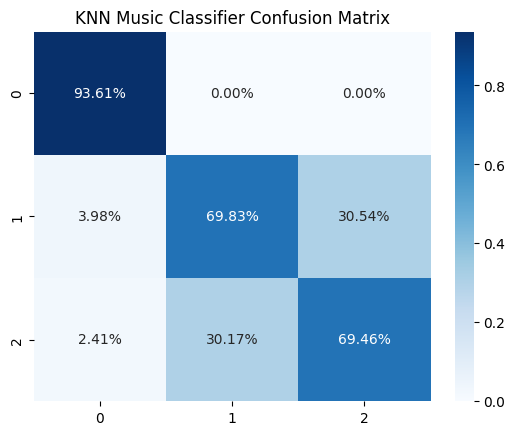

In [105]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_df = pd.DataFrame(conf_matrix, index=range(conf_matrix.shape[0]), columns=range(conf_matrix.shape[1]))
conf_df
## add title in heatmap
sns.heatmap(conf_df/np.sum(conf_df), annot=True, 
            fmt='.2%', cmap='Blues').set(title="KNN Music Classifier Confusion Matrix")

c:\Users\g.agluba\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


array([2, 1, 1, ..., 2, 2, 2], dtype=int64)